https://github.com/therealoliver/Deepdive-llama3-from-scratch/blob/main/README_zh.md

**环境准备**
- 下载模型：modelscope download --model LLM-Research/Llama-3.2-1B-Instruct --local_dir ./Llama-3.2-1B-Instruct
- 下载pip包：pip install sentencepiece tiktoken torch blobfile matplotlib

# 加载模型

## 加载分词器tokenizer
tokenizer作用（原始文本 <-> Token）
- 文本拆分：Hello world -> ["hello", "world"]
- 映射：Hello -> 15496
- 处理特殊标记：[CLS]表示句子开头
- 反向映射：15496 -> Hello

加载基于BPE的tokenizer
- 加载模型字典（无特殊token）
- 加入特殊token到字典：手动定义或基于模型现有的（tokenizer_config.json）
- 定义文本分割规则：粗分割（基于正则）、细分割（基于BPE）
- 创建tokenizer：基于tiktoken创建文本编解码对象

In [1]:
# 加载基于BPE的tokenizer

# 导入相关库
from pathlib import Path  # 用于从文件路径中获取文件名/模型名
import tiktoken  # openai开发的开源库，用于文本编解码（文本和tokenid的相互转换）
from tiktoken.load import load_tiktoken_bpe  # 加载BPE模型
import torch  # 用于搭建模型和矩阵计算
import json  # 用于加载配置文件
import matplotlib.pyplot as plt  # 用于绘图

tokenizer_path = "/data/models/Llama-3.2-1B-Instruct/original/tokenizer.model"  # 分词器模型的路径

# 常规词典外的特殊token
# 在"Meta-Llama-3-8B/"路径下的'tokenizer.json'和'tokenizer_config.json'的added_tokens字段下都有这些特殊token
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",  # 保留了从0到250的特殊token，出于功能扩展性、任务兼容性和未来安全性的考虑
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",  # 头部信息的开始，用于标记包裹结构化数据的头部信息，如元数据
            "<|end_header_id|>",  # 头部信息的结束
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn，多轮对话里标记当前轮次对话的结束
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]

# 加载BPE模型（实际是一个字典）
# 一个字典，子词(bytes类型，用utf-8解码)-rank(id)对，128000词，不包含上面的256个特殊token（所以模型的总词典大小是128256）
# 其中rank值是从0递增的序列，用于决定子词单元合并的优先顺序，优先级越高的会优先合并，因此这里的名字是mergeable ranks而非BPE或字典等类似的名字
# 没把特殊token加到字典里应该是出于灵活性考虑，便于面对不同模型架构或任务有不同特殊token时添加特定的token，而且保持字典大小不变
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)

# 创建一个文本编解码器对象
# 其中的pat_str大致分为三个类型：带缩写的单词 & 单词、中文片段、1-3位的数字 & 其他特殊字符
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,  # 编码器名称，便于调试和日志记录使用的不同的编码器
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",  # 用于初步的粗分割文本为token序列的正则表达式
    mergeable_ranks=mergeable_ranks,  # 传入加载的BPE模型
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},  # 添加特殊token-id对的字典
)

# 测试是否创建成功，即编解码器是否能正确运行
print(tokenizer.decode(tokenizer.encode("create tokenizer successed!")))


# 下面是一个案例测试，来测试pat_str粗分割和tokenizer细分割的效果和区别
# pat_str的正则只是提供了一个初步的分割，一些长句子或中文等不会分割，会在tokenizer中进一步基于BPE算法进行细化分割
import regex  # 由于pat_str中用到了Unicode的一些语法，如\p{L}，所以不能用re库

## 创建正则
pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+"
pattern = regex.compile(pat_str)

## 文本切分
text = "Hello world! It's a test. 这是一个测试. alongwords. a long words. 123 456 789."  # 测试文本
re_tokens = pattern.findall(text)  # 使用正则表达式分割字符串
merge_tokens_id = tokenizer.encode(text)  # 使用tokenizer分割字符串
merge_tokens = [tokenizer.decode([i]) for i in merge_tokens_id]  # 将tokenizer分割结果的id序列转换为实际的子词序列

## 结果输出
print("原始字符串:", text)
print("正则分割结果:", re_tokens)
print("tokenizer分割结果:", merge_tokens)
print("tokenizer分割结果id:", list(zip(merge_tokens, merge_tokens_id)))

## 从结果将会看到所有单词的前缀空格都被保留了下来，而非单独一个空格token或将其删除，有利于模型正确理解单词间的边界信息，如例子中的alongwords

create tokenizer successed!
原始字符串: Hello world! It's a test. 这是一个测试. alongwords. a long words. 123 456 789.
正则分割结果: ['Hello', ' world', '!', ' It', "'s", ' a', ' test', '.', ' 这是一个测试', '.', ' alongwords', '.', ' a', ' long', ' words', '.', ' ', '123', ' ', '456', ' ', '789', '.']
tokenizer分割结果: ['Hello', ' world', '!', ' It', "'s", ' a', ' test', '.', ' 这', '是一个', '测试', '.', ' along', 'words', '.', ' a', ' long', ' words', '.', ' ', '123', ' ', '456', ' ', '789', '.']
tokenizer分割结果id: [('Hello', 9906), (' world', 1917), ('!', 0), (' It', 1102), ("'s", 596), (' a', 264), (' test', 1296), ('.', 13), (' 这', 122255), ('是一个', 122503), ('测试', 82805), ('.', 13), (' along', 3235), ('words', 5880), ('.', 13), (' a', 264), (' long', 1317), (' words', 4339), ('.', 13), (' ', 220), ('123', 4513), (' ', 220), ('456', 10961), (' ', 220), ('789', 16474), ('.', 13)]


## 读取模型文件和配置文件

In [8]:
import torch

# 加载模型，一个网络层名称-tensor类型参数的字典
model = torch.load("/data/models/Llama-3.2-1B-Instruct/original/consolidated.00.pth")

# 输出前20层网络名，验证是否正确加载
print(json.dumps(list(model.keys())[:20], indent=4))

# 加载配置文件，每个配置的具体含义见下节
with open("/data/models/Llama-3.2-1B-Instruct/original/params.json", "r") as f:
    config = json.load(f)
print(config)

# 记录这些配置，后面将逐渐用到
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

/tmp/ipykernel_909715/3527457204.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/data/models/Llama-3.2-1B-Instruct/original/consolidated.00.pth")


[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]
{'dim': 2048, 'n_layers': 16, 'n_heads': 32, 'n_kv_heads': 8, 'vocab_size': 128256, 'ffn_dim_multiplier': 1.5, 'multiple_of': 256, 'norm_eps': 1e-05, 'rope_theta': 500000.0, 'use_scaled_rope': True}


params.json详情
- dim：每个token表示的维度
- n_layers：模型的层数
- n_heads：多头注意力的头数。每个头有独立的注意力机制，以捕捉输入数据的不同特征或信息
- n_kv_heads：键值注意力的头数，用于分组查询注意力GQA，即键值注意力有8个头，而查询有n_heads=32个头，每4个查询头会共享一组键值对
- vocab_size：词汇表大小，128000个普通token，256个特殊token
- multiple_of：dim的倍数约束，从而优化计算效率
- ffn_dim_multiplier：前馈网络层的隐藏层维度乘数，用于计算FFN隐藏层维度
- norm_eps：层归一化计算中在分母里加的常量，防止除零，保证数值稳定性
- rope_theta：旋转位置编码RoPE中的基础频率缩放因子，控制位置编码的周期性和分辨率，从而影响模型对不同长度序列和位置关系的捕捉能力

attention计算流程
- 输入：input(L, 4096)
- 计算QKV：
    - query_proj(L, 128, 32)
    - key_proj(L, 128, 8)
    - value_proj(L, 128, 8)
- 计算GQA
    - group_query_attention(L, 128, 32)
    - output_proj(L, 4096)
- 输出：output(L, 4096)


# 将输入文本转换为嵌入向量

## 将文本转换为token id序列

In [6]:
# 将输入的文本prompt转换为token id序列
prompt = "the answer to the ultimate question of life, the universe, and everything is "  # 输入文本
tokens = [128000] + tokenizer.encode(prompt)  # 做子词切分，并在文本开头加入指示文本开始了的特殊token：<|begin_of_text|>，维度：[17]
print(tokens)  # 查看下切分后的结果
tokens = torch.tensor(tokens)  # 转换为张量类型，便于后续矩阵计算，[17]

# 将token id序列转换为具体的token子词序列，仅作为展示用，实际不需要
prompt_split_as_tokens = [tokenizer.decode([token]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


## 将token id序列转换为embedding嵌入向量

In [10]:
# 创建一个嵌入层网络，用于将离散的token id映射到连续的向量空间
embedding_layer = torch.nn.Embedding(vocab_size, dim)

# 将嵌入层网络的参数替换为llama3中预训练好的参数值
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])

# 使用嵌入层网络，将输入的token id序列转换为向量表示
# 嵌入层网络仅是基于id查字典来找到对应的向量，不涉及token间的交互
# [17] -> [17x4096]
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)  # 默认是float32全精度，这里换成半精度格式，降低内存占用

token_embeddings_unnormalized.shape

torch.Size([17, 2048])

# 构建第一层的transformer块

一个transformer块包含了
- 2次归一：attention_norm、ffn_norm
- 4个注意力权重：q、k、v、o
- 3个前馈网络层：feed_forward.w1、feed_forward.w2、feed_forward.w3

计算流程为：归一化->多头自注意力->残差连接->归一化->前馈神经网络->残差连接

In [13]:
# 展示第一层transformer块的所有权重参数及形状
for k, v in model.items():
    if not k.startswith('layers'):
        continue
    if k.startswith('layers.1'):
        break
    print(k, v.shape)

layers.0.attention.wq.weight torch.Size([2048, 2048])
layers.0.attention.wk.weight torch.Size([512, 2048])
layers.0.attention.wv.weight torch.Size([512, 2048])
layers.0.attention.wo.weight torch.Size([2048, 2048])
layers.0.feed_forward.w1.weight torch.Size([8192, 2048])
layers.0.feed_forward.w3.weight torch.Size([8192, 2048])
layers.0.feed_forward.w2.weight torch.Size([2048, 8192])
layers.0.attention_norm.weight torch.Size([2048])
layers.0.ffn_norm.weight torch.Size([2048])


其中
- 权重矩阵形状为(输出维度，输入维度)，进行计算时会转置为(输入维度, 输出维度)
- 由于llama3是分组注意力机制，因此每4个查询头会共享一组kv向量，所以kv的权重矩阵维度为[1024, 4096]，是q（[4096, 4096]）的1/4

## 归一化
- 在约束数据的尺度差异，避免因为向量值的差异过大而导致训练的不稳定等问题
- 归一前后，数据形状不变

使用RMS归一化embedding嵌入
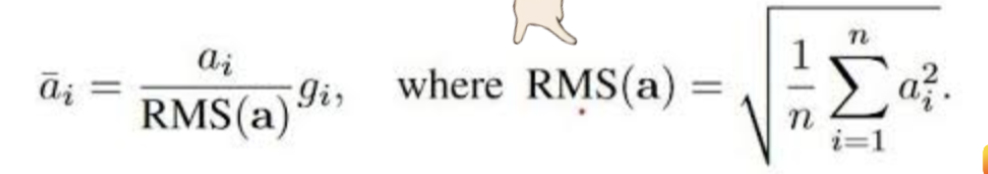
其中$g_i$是训练过程中学习的缩放因子

In [15]:
# 定义RMS归一化的计算函数
# 会将每个token进行独立的归一化
# norm_weights为预训练的缩放因子（即公式中的gi），以增强模型的表达能力。可以从模型文件中加载，4096维
# torch.rsqrt计算tensor的平方根的倒数，即1/RMS(a)
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

In [19]:
# fix：Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!
token_embeddings_unnormalized = token_embeddings_unnormalized.to('cuda')
# 归一化输入
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
model["layers.0.attention_norm.weight"].shape, token_embeddings.shape

(torch.Size([2048]), torch.Size([17, 2048]))

## 从零实现单头的attention注意力机制
📌 32个注意力头的计算完全相同、相互独立
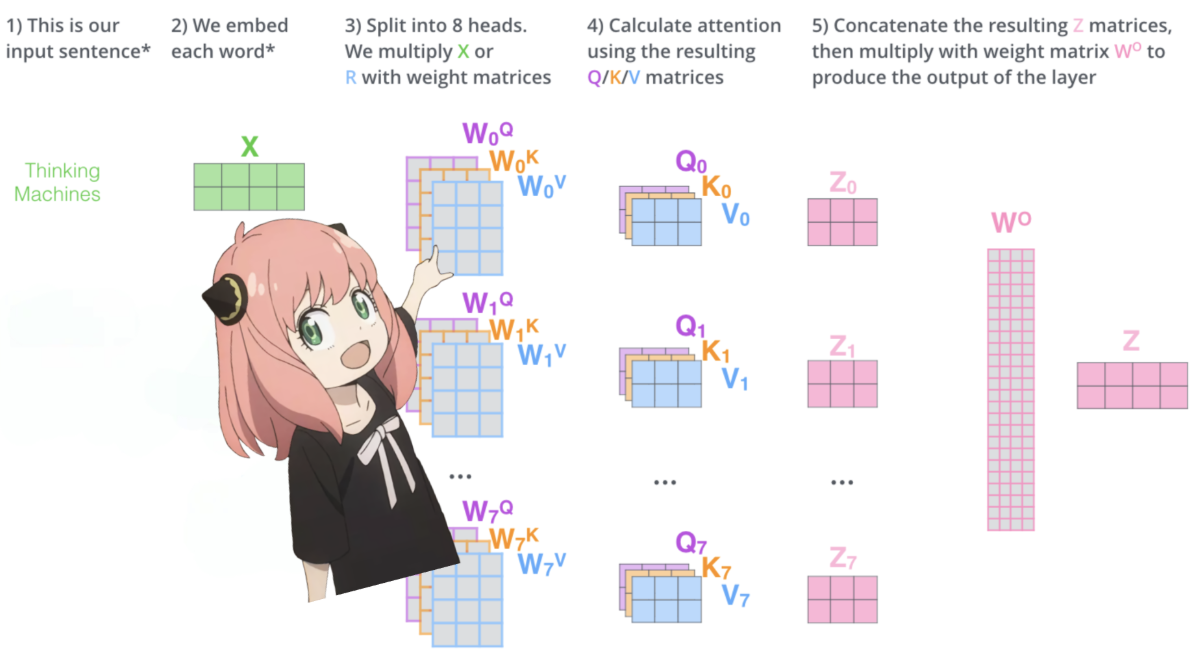
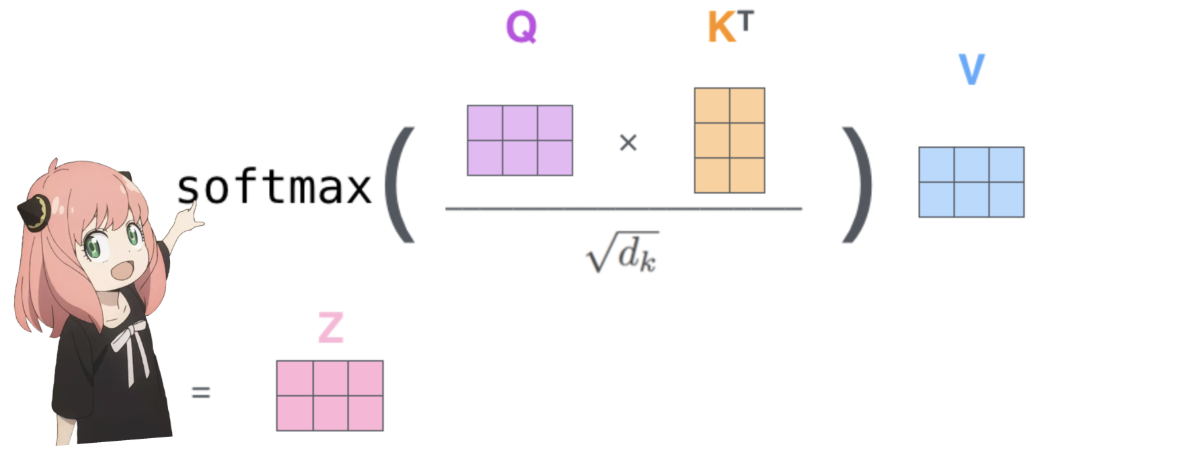
### 计算流程
- 对输入的embedding进行线性变换，得到q、k、v
- 计算QK得到自注意力权重，即对每个token来说，其他token对它的重要性
- 基于自注意力权重，对v进行加权，得到每个token的注意力结果


In [26]:
# 展示当前的q,k,v和o的注意力权重矩阵形状
print(
    model["layers.0.attention.wq.weight"].shape,  # [4096x4096]
    model["layers.0.attention.wk.weight"].shape,  # [1024x4096]
    model["layers.0.attention.wv.weight"].shape,  # [1024x4096]
    model["layers.0.attention.wo.weight"].shape   # [4096x4096]
)

torch.Size([2048, 2048]) torch.Size([512, 2048]) torch.Size([512, 2048]) torch.Size([2048, 2048])


### 计算q

In [27]:
# 加载并修改layers.0的query权重矩阵的形状，使其以多头的形式展开
q_layer0 = model["layers.0.attention.wq.weight"]  # 默认形状为[4096x4096]
head_dim = q_layer0.shape[0] // n_heads  # 注意力头的维度，4096/32=128
q_layer0 = q_layer0.view(n_heads, head_dim, dim)  # 展开后的维度，[32x128x4096]
q_layer0.shape

torch.Size([32, 64, 2048])

In [24]:
# 取出第一个头的权重
q_layer0_head0 = q_layer0[0]  # [32x128x4096] -> [128x4096]
q_layer0_head0.shape

torch.Size([64, 2048])

In [25]:
# 计算输入在第一个query头上得到的query值
# Q0_head0 = XW0_Q_head0.T
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)  # [17x4096] x [4096x128] = [17x128]
q_per_token.shape

torch.Size([17, 64])

### 计算k

In [28]:
# 加载并修改layers.0的key权重矩阵的形状，使其以多头的形式展开
# 与query权重矩阵不同，key为8个注意力头，因此参数量为query矩阵的1/4
k_layer0 = model["layers.0.attention.wk.weight"]  # [1024x4096]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim) # [8x128x4096]
k_layer0.shape

torch.Size([8, 64, 2048])

In [29]:
# 取出第一个头的权重矩阵
k_layer0_head0 = k_layer0[0]  # [8x128x4096] -> [128x4096]
k_layer0_head0.shape

torch.Size([64, 2048])

In [30]:
# 计算第一个头的token嵌入对应的key向量
# K0_head0 = XW0_K_head0.T
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)  # [17x4096] x [4096x128] = [17x128]
k_per_token.shape

torch.Size([17, 64])

### 计算v

In [31]:
# 加载并修改layers.0的value权重矩阵的形状，使其以多头的形式展开
# 与key权重矩阵一样，value同样为8个注意力头，因此参数量同样为query矩阵的1/4
v_layer0 = model["layers.0.attention.wv.weight"]  # [1024x4096]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)  # [1024x4096] -> [8x128x4096]
v_layer0.shape

torch.Size([8, 64, 2048])

In [32]:
# 取出第一个头的权重矩阵
v_layer0_head0 = v_layer0[0]  # [8x128x4096] -> [128x4096]
v_layer0_head0.shape

torch.Size([64, 2048])

In [33]:
# 计算第一个头的token嵌入对应的value向量
# V0_head0 = XW0_V_head0.T
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)  # [17x4096] x [4096x128] = [17x128]
v_per_token.shape

torch.Size([17, 64])

### 向query和key向量添加位置信息(旋转编码)
- 词语之间的顺序关系和相对位置很重要
- 注意力需要提供token间的位置信息，从而更好地捕获序列的依赖
- 为什么向q、k添加：q和k用来计算注意力权重
- 为什么不向v添加：v只是用来做加权求和，位置信息已在q、k中被考虑

给query向量添加位置信息

In [42]:
# 将query向量在维度方向上两两分组
# [17x128] -> [17x64x2]
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)  # 换回了全精度，保证后续三角函数计算时的精度和数值稳定性
q_per_token_split_into_pairs.shape

torch.Size([17, 32, 2])

In [43]:
# 计算θ，第一步，得到 i/D
# [64]
zero_to_one_split_into_64_parts = torch.tensor(range(32))/32  # 每个特征分割后具有64个维度对，因此需要64个θ值
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0312, 0.0625, 0.0938, 0.1250, 0.1562, 0.1875, 0.2188, 0.2500,
        0.2812, 0.3125, 0.3438, 0.3750, 0.4062, 0.4375, 0.4688, 0.5000, 0.5312,
        0.5625, 0.5938, 0.6250, 0.6562, 0.6875, 0.7188, 0.7500, 0.7812, 0.8125,
        0.8438, 0.8750, 0.9062, 0.9375, 0.9688])

In [44]:
# 计算θ，第二步，得到 θ
# rope_theta用于控制位置编码的周期性等信息，详情可见配置信息章节
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)  # [64]
freqs

tensor([1.0000e+00, 6.6360e-01, 4.4037e-01, 2.9223e-01, 1.9392e-01, 1.2869e-01,
        8.5397e-02, 5.6670e-02, 3.7606e-02, 2.4955e-02, 1.6560e-02, 1.0990e-02,
        7.2927e-03, 4.8394e-03, 3.2114e-03, 2.1311e-03, 1.4142e-03, 9.3847e-04,
        6.2277e-04, 4.1327e-04, 2.7425e-04, 1.8199e-04, 1.2077e-04, 8.0143e-05,
        5.3183e-05, 3.5292e-05, 2.3420e-05, 1.5542e-05, 1.0313e-05, 6.8440e-06,
        4.5417e-06, 3.0139e-06])

In [45]:
# 计算mθ
# outer为外积计算，arange(17)即每个向量对应的m（输入为17个token，因此需要17个m值）
# 结果为[17x64]的形状，即每个token对应的向量都有64个mθ值，用于计算64个维度对各自的旋转
freqs_for_each_token = torch.outer(torch.arange(17), freqs)  # [17] & [64] -> [17x64]

torch.Size([17, 32])


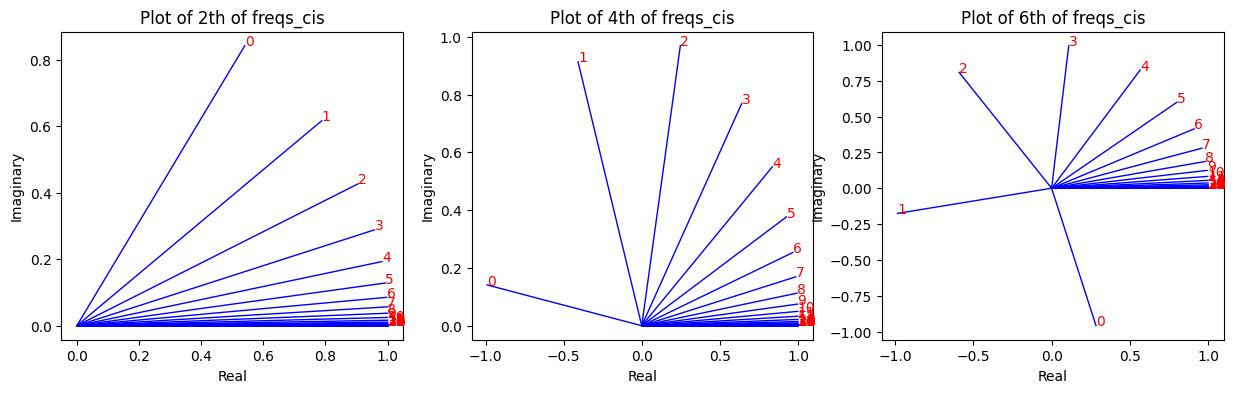

'\n注：从展示图可以看出，token位置越靠后的旋转角度越大，而单个token内的向量维度越靠前的旋转角度越大。\n    其中是否有数学上的考量可自行进一步探索X_X\n'

In [46]:
# 得到(cosmθ + sinmθi)，即将mθ转换为复数形式
# 将旋转角度mθ看做是模长为1的极坐标形式，从而将其转换为复数表示
# polar的两个输入分别表示模长（设为1，即只改变角度，不影响长度）和角度（即mθ）
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)  # [17x64] -> [17x64]
print(freqs_cis.shape)

# 查看部分位置的freqs_cis，仅展示用
token_to_show = [1, 3, 5]  # 查看第2,4,6行
fig, axs = plt.subplots(1, len(token_to_show), figsize=(5 * len(token_to_show), 4))  # 生成1行3列的3个子图图形窗口
for i, index in enumerate(token_to_show):
    value = freqs_cis[index]
    for j, element in enumerate(value):
        axs[i].plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {j}")  # 以实部为横坐标，虚部为纵坐标，绘制从原点到坐标点的蓝线
        axs[i].annotate(f"{j}", xy=(element.real, element.imag), color='red')  # 绘制红色的数字注释，表示第i对维度
    axs[i].set_xlabel('Real')
    axs[i].set_ylabel('Imaginary')
    axs[i].set_title(f'Plot of {index + 1}th of freqs_cis')
plt.show()

"""
注：从展示图可以看出，token位置越靠后的旋转角度越大，而单个token内的向量维度越靠前的旋转角度越大。
    其中是否有数学上的考量可自行进一步探索X_X
"""

In [47]:
# 得到(x + yi)
# 即把维度对转换为复数，转换后的维度将从[17x64x2]变为[17x64]
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)  # [17x64x2] -> [17x64]
q_per_token_as_complex_numbers.shape

torch.Size([17, 32])

In [49]:
# 计算(x + yi) * (cosmθ + sinmθi)
# 即执行旋转操作，得到最终结果
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis.to('cuda')  # [17x64] * [17x64] = [17x64]
q_per_token_as_complex_numbers_rotated.shape

torch.Size([17, 32])

In [50]:
# 将复数结果还原回实数的维度对形式
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)  # [17x64] -> [17x64x2]
q_per_token_split_into_pairs_rotated.shape

torch.Size([17, 32, 2])

In [51]:
# 将维度对结果还原回原始query向量形式
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)  # [17x64x2] -> [17x128]
q_per_token_rotated.shape

torch.Size([17, 64])

给key向量也添加位置信息（和query向量过程一样）

In [54]:
# 将key向量在维度方向上两两切分，形成维度对（修改形状）
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)  # [17x128] -> [17x64x2]
k_per_token_split_into_pairs.shape

# 得到(x + yi)
# 即将维度对转换为复数形式
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)  # [17x64x2] -> [17x64]
k_per_token_as_complex_numbers.shape

# 得到(x + yi) * (cosmθ + sinmθi)，即旋转位置编码后的最终结果
# 并将结果还原回实数形式
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis.to('cuda'))  # [17x64] * [17x64] = [17x64] -> [17x64x2]
k_per_token_split_into_pairs_rotated.shape

# 将维度对还原回原始key向量形式，得到最终的key向量
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)  # [17x64x2] -> [17x128]
k_per_token_rotated.shape

torch.Size([17, 64])

### 计算token间的注意力权重
三步过程
- 计算注意力分数：score = Q x K
- 屏蔽未来token部分：score = mask(score)
- 计算注意力权重：res = softmax(score)

In [55]:
# 计算注意力分数
# 同时进行归一化，防止后续softmax计算结果过于偏向0或1（维度较大时的点积值可能过大），而导致梯度消失或梯度爆炸，以维持数值稳定性
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5  # [17x128] x [128x17] = [17x17]
qk_per_token.shape

torch.Size([17, 17])

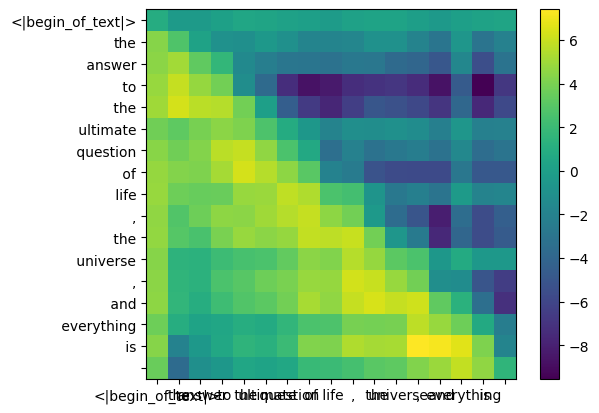

In [57]:
# 首先查看一下屏蔽前的分数矩阵
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()  # 创建图形窗口

    # imshow通常用于显示二维数组或矩阵形式的数据，将矩阵元素映射为灰度或彩色值，因此可用于绘制热力图
    # 将张量转换回全精度，然后从计算图中分离出来（detach），避免涉及到潜在的梯度计算和存储问题
    # 并指定使用viridis颜色映射方案来显示图像（蓝->绿->黄）
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')

    # 设定xy轴的刻度数量和标签，保证正确的一一对应
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)

    # 添加侧方颜色条
    # 指定im以识别正确的颜色映射和值的范围
    # 指定所属的子图为ax（若有多个子图，则ax=ax[i]）
    ax.figure.colorbar(im, ax=ax)

display_qk_heatmap(qk_per_token.cpu())

In [58]:
# 生成屏蔽矩阵
# 让需要屏蔽的元素位置设置为负无穷，而不需要屏蔽的位置设为0，后续将其与分数矩阵相加即可实现屏蔽效果（负无穷在计算softmax时将趋于0）

# torch.full用于生成指定形状和指定填充值的张量，这里首先生成了全为负无穷的[17x17]矩阵
# 指定该矩阵位置与之前token的位置相同，以确保后续计算时不出错（例如：如果之前的token在gpu上，而这里不指定设备，则mask将新建在cpu上，二者相加时将会报错）
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)  # [17x17]

# torch.triu用于返回矩阵的上三角部分，其余部分置为0（取下三角使用torch.tril）
# diagonal为对角线的偏移量，等于1时表示从主对角线向上偏移1个位置开始取上三角部分，以避免屏蔽自身token
mask = torch.triu(mask, diagonal=1)  # [17x17]

mask, mask.shape

(tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf,

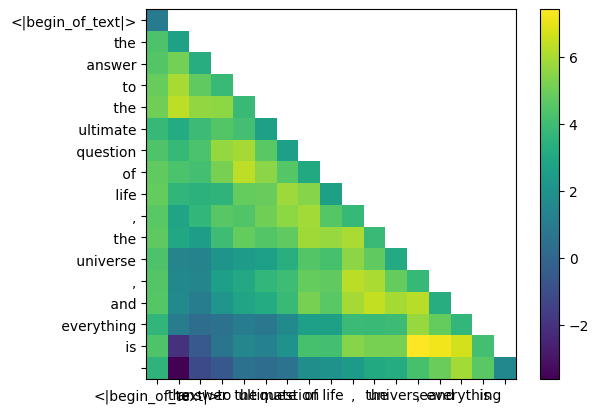

In [61]:
# 屏蔽未来token的分数
qk_per_token_after_masking = qk_per_token + mask.cuda()  # [17x17] + [17x17] = [17x17]
display_qk_heatmap(qk_per_token_after_masking.cpu())  # 展示屏蔽后的注意力分数

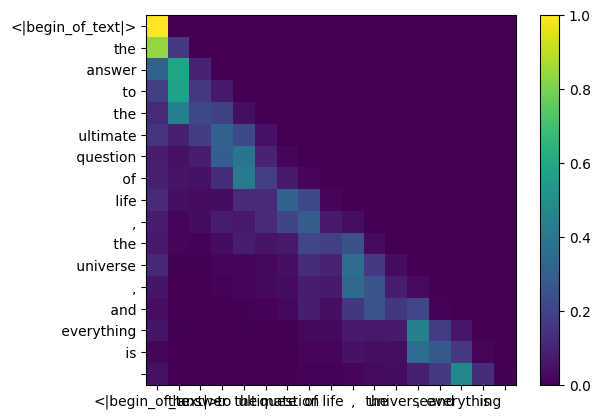

In [66]:
# 计算注意力权重
# 即计算分数的softmax值
# dim=1表示按行进行softmax的计算，结果转换为半精度，与之后的value向量保持一致
# softmax不会改变tensor形状
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)  # [17x17] -> [17x17]
display_qk_heatmap(qk_per_token_after_masking_after_softmax.cpu())

注意力权重使用原理
- 注意力权重（0-1）用于确定每个token使用多少比例的value
- 假如输入3个token，第一个token的注意力可能是res=0.6 * value_1 + 0.3 * value_2 + 0.1 * value_3

In [69]:
# 计算单头注意力的最终结果
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)  # [17x17] x [17x128] = [17x128]
qkv_attention.shape

torch.Size([17, 64])

llama3代码实现中，多头注意力计算采取了一次性矩阵乘法的方式，而非费时的for循环计算，大致过程如下
- 计算qkv向量：[17, 4096] x [4096, 4096]或[4096, 1024] = [17, 4096]或[17, 1024]
- 将qkv向量形状转为[32, 17, 128]或[8, 17, 128]
- 复制kv，使其与q保持一致，均为[32, 17, 128]
- q x k最后两维转置，计算score：[32, 17, 128] x [32, 128, 17] = [32, 17, 17]

In [77]:
# 计算多头注意力结果
# 即之前的单头注意力计算过程的循环
qkv_attention_store = []

for head in range(n_heads):
    # 取出当前头对应的qkv权重矩阵
    q_layer0_head = q_layer0[head] # [32x128x4096] -> [128x4096]
    k_layer0_head = k_layer0[head//4] # 每4个头共享一个key权重，[8x128x4096] -> [128x4096]
    v_layer0_head = v_layer0[head//4] # 每4个头共享一个value权重，[8x128x4096] -> [128x4096]

    # 计算XW，得到qkv向量
    # [17, 4096] x [4096, 128] = [17, 128]
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)
    
    # 给query向量加入位置信息（RoPE）
    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2) # 维度方向进行两两分组，组成维度对，[17x128] -> [17x64x2]
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs) # 转换为复数表示，(x,y) -> (x+yi)，[17x64x2] -> [17x64]
    q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis[:len(tokens)].to('cuda') # 计算(x+yi)*(cosmθ+sinmθi)，完成旋转操作，[17x64] * [17x64] = [17x64]
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated) # 结果还原回实数表示，(x+yi) -> (x,y)，[17x64] -> [17x64x2]
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape) # 结果还原回原始向量形状，得到最终的query向量，[17x64x2] -> [17x128]

    # 给key向量加入位置信息（RoPE）
    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)  # 维度方向进行两两分组，组成维度对，[17x128] -> [17x64x2]
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)  # 转换为复数表示，(x,y) -> (x+yi)，[17x64x2] -> [17x64]
    k_per_token_as_complex_numbers_rotated = k_per_token_as_complex_numbers * freqs_cis[:len(tokens)].to('cuda')  # 计算(x+yi)*(cosmθ+sinmθi)，完成旋转操作，[17x64] * [17x64] = [17x64]
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers_rotated)  # 结果还原回实数表示，(x+yi) -> (x,y)，[17x64] -> [17x64x2]
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)  # 结果还原回原始向量形状，得到最终的key向量，[17x64x2] -> [17x128]

    # 计算注意力分数，同时归一化分数（即QxK/sqrt(dim)）
    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5 # [17x128] x [128x17] = [17x17]

    # 屏蔽未来token的分数
    mask = torch.full(qk_per_token.shape, float("-inf"), device=tokens.device)  # 创建和注意力分数相同形状，值全为负无穷的矩阵，并保证存储位置和其他向量一致，防止后续计算时错误，[17x17]
    mask = torch.triu(mask, diagonal=1) # 保留上三角部分的负无穷，将下三角设为0（即上三角区域为未来token需要屏蔽，下三角为当前及以前的token无需屏蔽），对角线偏移量为1，避免屏蔽自身token，[17x17]
    qk_per_token_after_masking = qk_per_token + mask.to('cuda') # 注意力分数与屏蔽矩阵相加，使分数矩阵的上三角变为负无穷，后续softmax后将趋于0，[17x17]

    # 计算注意力分数（即softmax(score)）
    # 同时变换回半精度（因为后续要和value向量v_per_token相乘，需要保证数据类型相同）
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)  # 按行计算softmax，[17x17]

    # 计算注意力机制的最终结果（即softmax(score) x v）
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token) # [17x17] x [17x128] = [17x128]

    # 记录该头结果
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

合并每个头为一个大矩阵
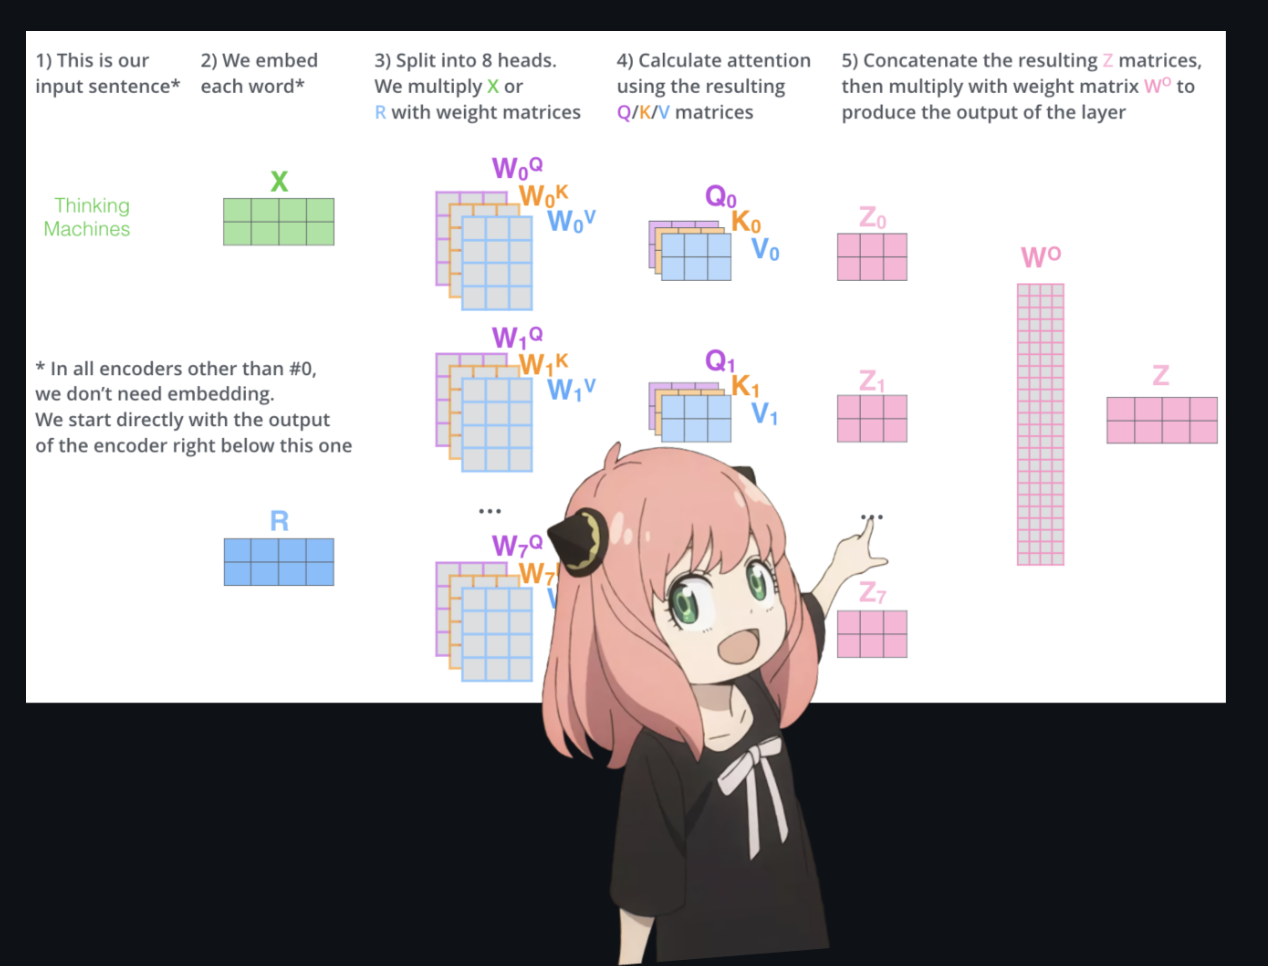

In [80]:
# 合并多头注意力矩阵
print(f'shape before cat {qkv_attention_store[0].shape}')
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)  # 将第二维合并，即32个[17x128] -> [17x4096]
stacked_qkv_attention.shape

shape before cat torch.Size([17, 64])


torch.Size([17, 2048])

头间信息交互（线性映射），自注意力层的最后一步！
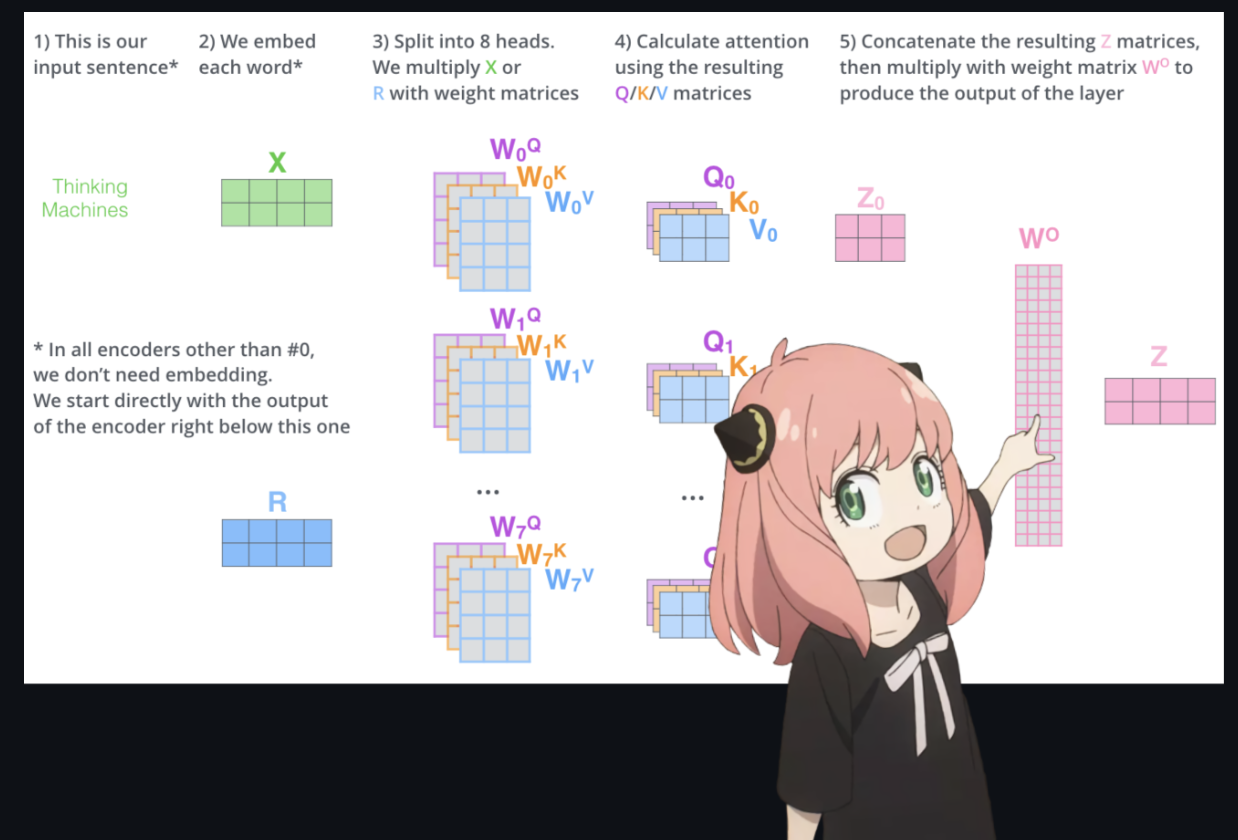

In [81]:
# 加载layers.0的output权重矩阵
w_layer0 = model["layers.0.attention.wo.weight"]  # [4096x4096]
w_layer0.shape

torch.Size([2048, 2048])

In [82]:
# 进行注意力矩阵的线性映射
# 这就是注意力层的最终输出结果了
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)  # [17x4096] x [4096x4096] = [17x4096]
embedding_delta.shape

torch.Size([17, 2048])

进行一下残差操作
- 注意力机制作用后的值 + 添加原始的输入向量
- 保证信息的不易丢失，并缓解梯度消失问题

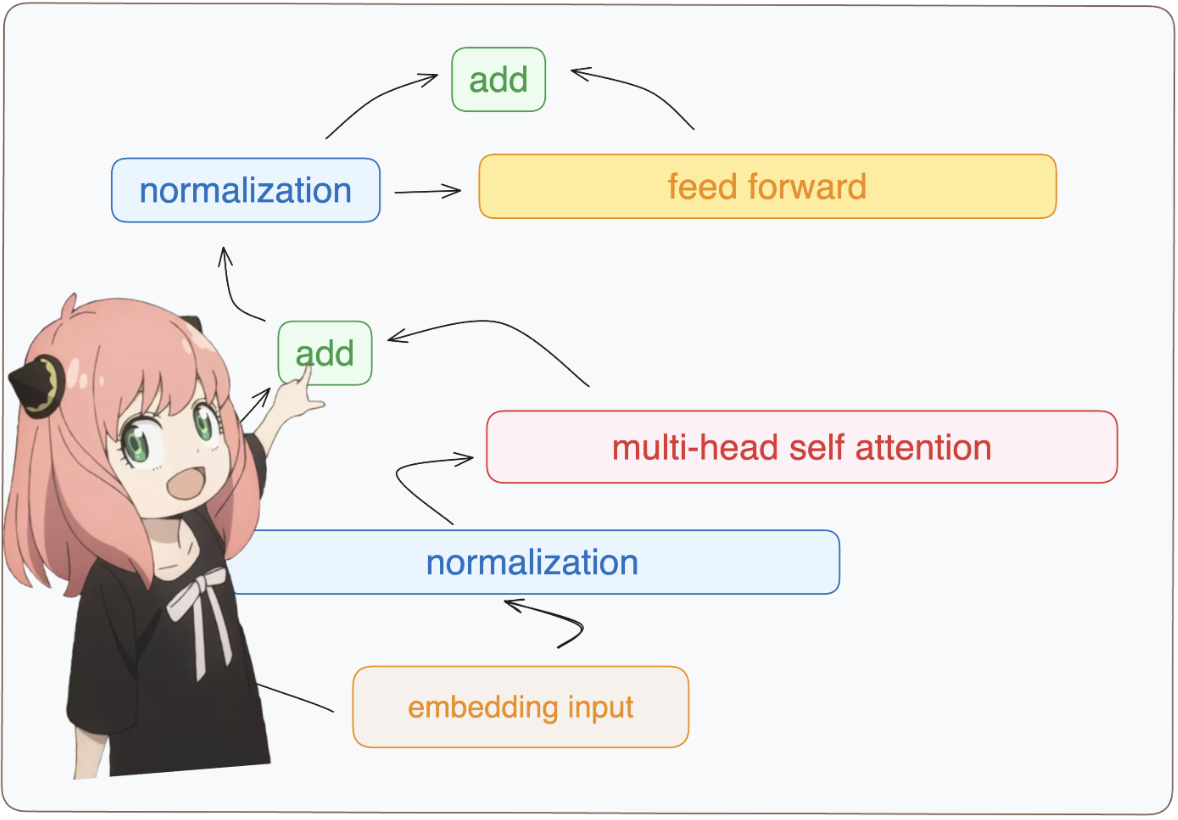

In [83]:
# 将attention层的输出与原始输入相加，完成残差操作
embedding_after_edit = token_embeddings_unnormalized + embedding_delta  # [17x4096] + [17x4096] = [17x4096]
embedding_after_edit.shape

torch.Size([17, 2048])

进行第二次的归一化操作
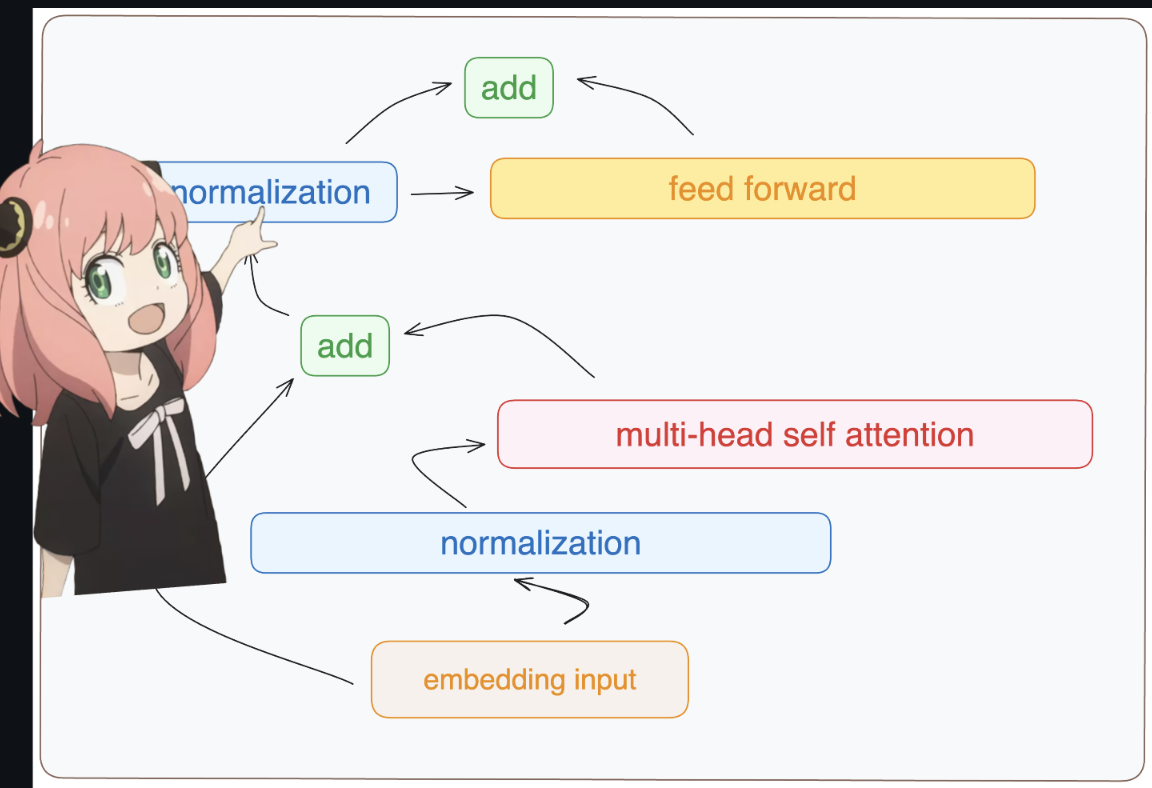

In [84]:
# 将残差结果再进行一下归一化
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
embedding_after_edit_normalized.shape

torch.Size([17, 2048])

进行ffn前馈网络层的计算
- why：增加非线性特性，增加模型的表达能力（底层网络识别语言结构，高层网络识别更复杂的情感、意图）
- how：SwiGLU网络
    - 将输入进行线性变换：$X' = XW_3$
    - 门控单元：$GATE = Activation_Function(XW_1)$，用于选择有用的通过信息，本质上是门控单元的分数对信息进行加权通过，进而提升模型的表达能力
    - 激活函数：$Swish = X \sigma(\beta X)，其中\sigma是sigmoid激活函数，\beta是一个可学习参数$

In [86]:
# 计算前馈网络层
# 隐藏层维度大小为14336
w1 = model["layers.0.feed_forward.w1.weight"]  # [14336x4096]
w3 = model["layers.0.feed_forward.w3.weight"]  # [14336x4096]
w2 = model["layers.0.feed_forward.w2.weight"]  # [4096x14336]
print(w1.shape, w3.shape, w2.shape)

# output = (silu(XW1) * XW3)W2
# [17x4096] x [4096x14336] x [14336x4096] = [17x4096]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([8192, 2048]) torch.Size([8192, 2048]) torch.Size([2048, 8192])


torch.Size([17, 2048])

再次进行一下残差操作

In [87]:
# 将前馈层的输出与原始输入相加，完成残差操作
# 这就是一个transformer块的最终结果了
layer_0_embedding = embedding_after_edit+output_after_feedforward  # [17x4096] + [17x4096] = [17x4096]
layer_0_embedding.shape

torch.Size([17, 2048])

### 汇总
- 每个token进过一层后，得到形状相同的新向量
- 此时token包含了该层所有token的信息
- 循环对每一层进行处理，得到最终输出

In [94]:
# 现在开始完成全部的32层transformer块的计算！

# 输入token的嵌入向量作为初始值
final_embedding = token_embeddings_unnormalized  # [17x4096]

# 32层transformer块逐层计算
for layer in range(n_layers):
    #########################################################################################################################
    ###################################### 第一轮 归一化-特征变换-残差 ######################################################
    
    ########################### 第一次归一化 ###################################################
    
    # 第一次归一化
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
    
    ########################### 第一次特征变换-多头自注意力 #####################################
    
    # 获取当前层注意力机制的qkv权重矩阵
    q_layer = model[f"layers.{layer}.attention.wq.weight"]  # [4096x4096]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)  # [32x128x4096]
    k_layer = model[f"layers.{layer}.attention.wk.weight"]  # [1024x4096]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)  # [8x128x4096]
    v_layer = model[f"layers.{layer}.attention.wv.weight"]  # [1024x4096]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)  # [8x128x4096]
    
    # 用于存储每个头的注意力机制计算结果
    qkv_attention_store = []
    
    # 计算每个头的注意力机制结果
    for head in range(n_heads):
        # 取出当前头的qkv权重矩阵
        q_layer_head = q_layer[head]  # [32x128x4096] -> [128x4096]
        k_layer_head = k_layer[head//4]  # 每4个头共享一个key权重，[8x128x4096] -> [128x4096]
        v_layer_head = v_layer[head//4]  # 每4个头共享一个value权重，[8x128x4096] -> [128x4096]
        
        # 计算XW，得到输入token的qkv向量
        # [17x4096] x [4096x128] = [17x128]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        
        # 给query向量加入位置信息（RoPE）
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)  # 维度方向进行两两分组，组成维度对，[17x128] -> [17x64x2]
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)  # 转换为复数表示，(x,y) -> (x+yi)，[17x64x2] -> [17x64]
        q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis.to('cuda')  # 计算(x+yi)*(cosmθ+sinmθi)，完成旋转操作，[17x64] * [17x64] = [17x64]
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)  # 结果还原回实数表示，(x+yi) -> (x,y)，[17x64] -> [17x64x2]
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)  # 结果还原回原始向量形状，得到最终的query向量，[17x64x2] -> [17x128]
        
        # 给key向量加入位置信息（RoPE）
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)  # 维度方向进行两两分组，组成维度对，[17x128] -> [17x64x2]
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)  # 转换为复数表示，(x,y) -> (x+yi)，[17x64x2] -> [17x64]
        k_per_token_as_complex_numbers_rotated = k_per_token_as_complex_numbers * freqs_cis.to('cuda')  # 计算(x+yi)*(cosmθ+sinmθi)，完成旋转操作，[17x64] * [17x64] = [17x64]
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers_rotated)  # 结果还原回实数表示，(x+yi) -> (x,y)，[17x64] -> [17x64x2]
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)  # 结果还原回原始向量形状，得到最终的key向量，[17x64x2] -> [17x128]
        
        # 计算注意力分数，同时归一化分数（即QxK/sqrt(dim)）
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5  # [17x128] x [128x17] = [17x17]
        
        # 屏蔽未来token的分数
        mask = torch.full(qk_per_token.shape, float("-inf"), device=qk_per_token.device)  # 创建和注意力分数相同形状，值全为负无穷的矩阵，并保证存储位置和其他向量一致，防止后续计算时错误，[17x17]
        mask = torch.triu(mask, diagonal=1)  # 保留上三角部分的负无穷，将下三角设为0（即上三角区域为未来token需要屏蔽，下三角为当前及以前的token无需屏蔽），对角线偏移量为1，避免屏蔽自身token，[17x17]
        qk_per_token_after_masking = qk_per_token + mask  # 注意力分数与屏蔽矩阵相加，使分数矩阵的上三角变为负无穷，后续softmax后将趋于0，[17x17]
        
        # 计算注意力权重（即softmax(score)）
        # 同时变换回半精度（因为后续要和value向量v_per_token相乘，需要保证数据类型相同）
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)  # 按行计算softmax，[17x17]
        
        # 计算注意力机制的最终结果（即softmax(score)xV）
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)  # [17x17] x [17x128] = [17x128]
        
        # 记录该头结果
        qkv_attention_store.append(qkv_attention)
    
    # 合并多头注意力结果
    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)  # 将第二维合并，即32个[17x128] -> [17x4096]
    
    # 结果做线性映射，生成最终的多头自注意力机制结果
    o_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, o_layer.T)  # [17x4096] x [4096x4096] = [17x4096]
    
    ########################### 第一次残差连接 ################################################
    
    # 第一次残差
    # 将attention层的输出与原始输入相加，完成残差操作
    embedding_after_edit = final_embedding + embedding_delta  # [17x4096] + [17x4096] = [17x4096]
    
    
    #########################################################################################################################
    ###################################### 第二轮 归一化-特征变换-残差 ######################################################
    
    ########################### 第二次归一化 ###################################################
    
    # 第二次归一化
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])  # [17x4096] & [4096] -> [17x4096]
    
    ########################### 第二次特征变换-前馈神经网络 #####################################
    
    # 加载前馈网络（SwiGLU）参数矩阵
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]  # [14336x4096]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]  # [14336x4096]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]  # [4096x14336]
    
    # 计算前馈网络结果（output = (silu(XW1) * XW3)W2）
    # [17x4096] x [4096x14336] x [14336x4096] = [17x4096]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    
    ########################### 第二次残差连接 ##################################################
    
    # 第二次残差，得到当前transformer块的最终输出结果
    # 将前馈层的输出与原始输入相加，完成残差操作
    final_embedding = embedding_after_edit+output_after_feedforward  # [17x4096] + [17x4096] = [17x4096]

In [95]:
## 预测下一个token

In [96]:
# 进行整个模型中最后一次的归一化
final_embedding = rms_norm(final_embedding, model["norm.weight"])  # [17x4096] & [4096] -> [17x4096]
final_embedding.shape

torch.Size([17, 2048])

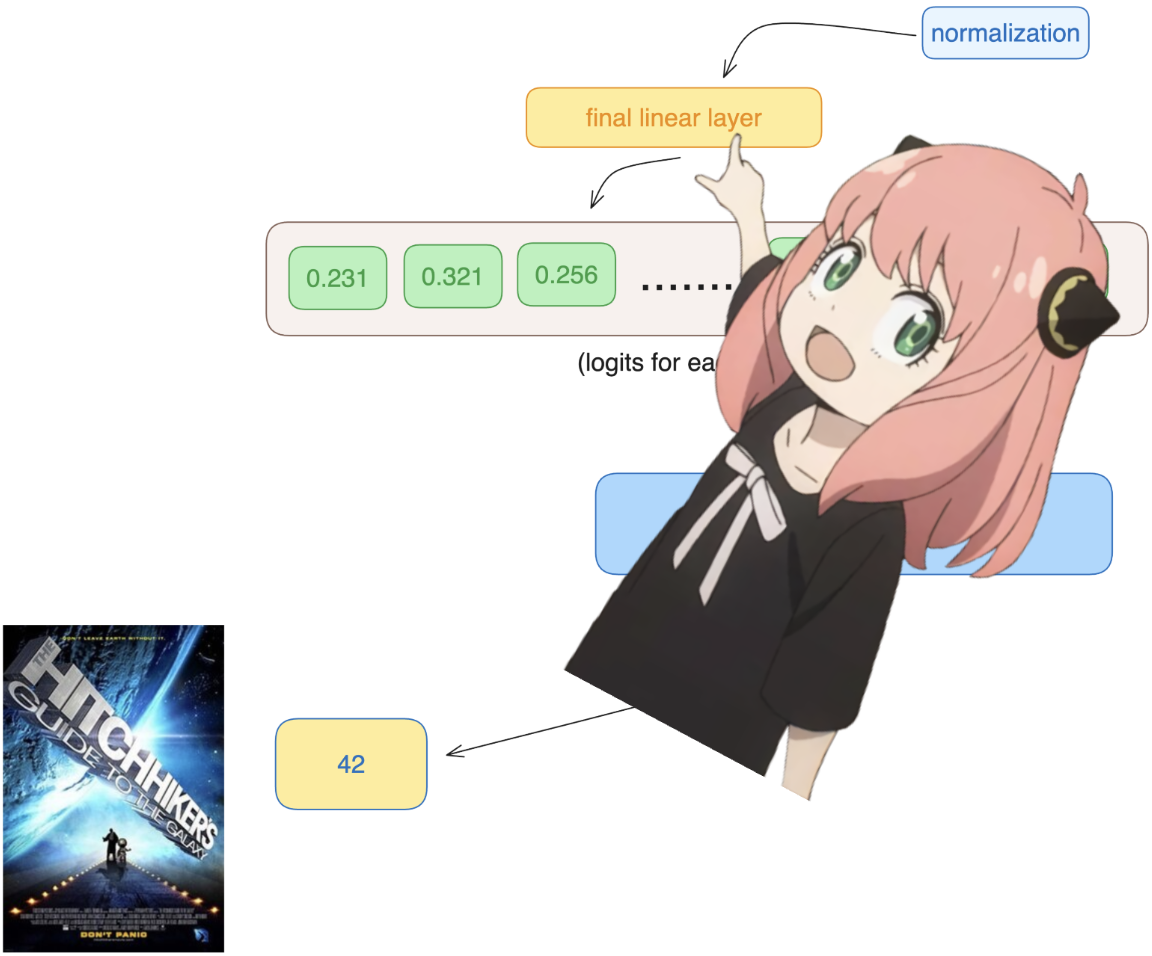

In [97]:
# 对最后一个词进行线性映射
# 最后一次的线性映射，将嵌入向量映射成词典维度大小，以作为对下一个token的预测
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)  # [17x4096] -> [4096] -> [4096] x [4096x128256] = [128256]
logits.shape

torch.Size([128256])

In [105]:
# 取出概率最大的那一维对应的id，即预测的下一个token的id
next_token = torch.argmax(logits, dim=-1)  # 获取最大值对应的下标，即预测的下一个token id，[128256] -> [1]
next_token

tensor(2983, device='cuda:0')

In [106]:
# 基于预测的id，还原回具体预测的值
tokenizer.decode([next_token.item()])

'42'

📌 为什么只选取最后一个token对应的输出向量来进行下一个token的预测？

因为模型在训练时的目标为基于当前token及以前的信息，预测下一个token，因此，每一个token对应的输出向量都是在预测相对于它自己的下一个token，而非整个输入的下一个token

📌 42是“the answer to the ultimate question of life, the universe, and everything is ”（“关于生命，宇宙和一切事情的终极答案是：”）的答案，根据“银河系漫游指南”这本书，大多数的现代大模型都会回答42，这将验证我们的整个代码的正确性！祝我们好运 :)

# 扩展
当前预测结果除了top-1，还预测了些什么，即top-k的结果

In [107]:
# 让我们先看一下top-k的预测结果
logits_sort, logits_idx = torch.sort(logits, dim=-1, descending=True)  # 对预测结果做排序，使最大可能性的预测token放前面，[128256]
[tokenizer.decode([i]) for i in logits_idx[:10]]  # 查看前10大概率的结果

['42', '17', '37', '43', '47', '9', ' ', '48', '7', '137']

如果使用其它token的嵌入向量来做预测，能够预测到什么

In [108]:
# 让我们再试一下用其他token的嵌入向量做预测能得到什么
logits_all_token = torch.matmul(final_embedding, model["output.weight"].T)  # 将嵌入向量映射成词典大小的维度，[17x4096] x [4096x128256] = [17x128256]
logits_all_token_sort, logits_all_token_idx = torch.sort(logits_all_token, dim=-1, descending=True)  # 对预测结果做排序，使最大可能性的预测token放前面，[17x128256]

print('输入的token：', prompt_split_as_tokens)  # 展示输入的token，[17]

# 展示基于每个token的嵌入向量所做的下一个token预测的结果
for i in range(len(final_embedding)):
    print(f'基于第{i+1}个token的嵌入向量的预测结果：', [tokenizer.decode([j]) for j in logits_all_token_idx[i][:10]])  # 输出前10大概率的结果
    
_="""
可以看到的是，基于每个token进行预测时，其预测结果为当前token后的下一个token的可能结果，而不是整个完整输入的预测结果，因此在实际预测时，会只使用最后一个token的嵌入向量来做预测
"""

输入的token： ['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']
基于第1个token的嵌入向量的预测结果： ['Tags', '#', '<?', 'import', 'The', 'package', 'def', 'Title', 'Home', '#!/']
基于第2个token的嵌入向量的预测结果： [' (', '\n', 'atre', 'book', 'ology', 'big', 'b', 'o', 'one', 'be']
基于第3个token的嵌入向量的预测结果： [' is', ' to', '\n', ' was', '\n\n', ',', ' lies', ':', ' will', ' would']
基于第4个token的嵌入向量的预测结果： [' the', ' this', ' life', ' a', ' that', ' all', ' your', ' what', ' "', ' how']
基于第5个token的嵌入向量的预测结果： [' question', ' r', ' ultimate', ' age', ' problem', ' mystery', ' classic', ' first', ' great', ' questions']
基于第6个token的嵌入向量的预测结果： [' question', ' mystery', ' questions', ' life', ' r', ' quest', ' truth', ' problem', ' puzzle', ' math']
基于第7个token的嵌入向量的预测结果： [' of', ' to', ' in', ' is', ',', ' about', '\n', ':', '...', ' that']
基于第8个token的嵌入向量的预测结果： [' life', ' existence', ' LIFE', ' the', ' all', ' Life', 

如果在当初的attention计算时，没有屏蔽未来token，那么预测结果会有什么样的不同

- 此时基于每个token的预测结果将变为如下所示
- 可以看到，由于未来token的可见性，基于每个token的嵌入向量都将更准确的预测出“对于它来说的”下一个token（有一点点“作弊”了）

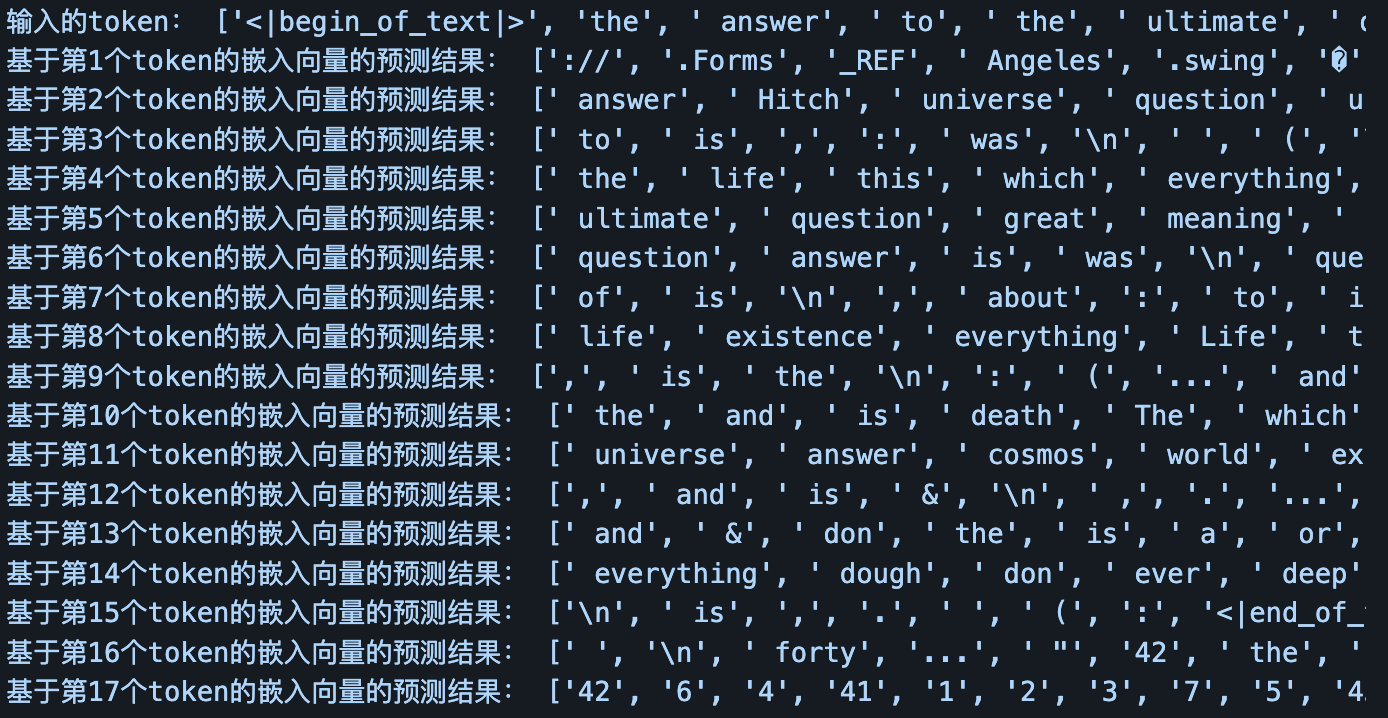

KV-Cache
- 大模型如何连续预测多个token：反复调用大模型的预测过程，直到遇到停止符或达到最大长度限制
- 工作机制：缓存历史token的KV向量，来减少输入及计算量
- 优势：持续预测时，每次只需要输入新的token即可，无需将完整的文本序列全部输入进来，从而极大提升推理时计算速度
- 劣势：由于缓存机制的存在，在推理时会额外占用较多的内存资源
- 原理
    - 非注意力部分只需计算新token：除了注意力计算以外，所有部分的计算都是token间相互独立的，因此只需要计算新token即可，可以不用输入历史token
    - 注意力部分也只需计算新token：注意力层中，由于屏蔽机制的存在，历史token的输出结果不会受未来新token的影响，因此其在每一层的输入和输出都是固定不变的，即历史token的QKV向量都不会因为加入新token而改变，从而只需要计算新token的注意力即可
    - 新token注意力机制计算：注意力层用来让token获取历史token的上下文信息，所以需要为每个新token都使用全部token的value向量进行加权和，因此需要存储历史token的value
    - 新token注意力权重计算：由第4条可知，我们还需要先获取新token与历史token间的重要性信息，即权重，所以需要计算新token与所有token的key向量乘积，因此需要存储历史token的key
    - KV-Cache的获取：由第4,5条可知，我们需要存储历史token的KV向量，而query向量因为没有用到，所以不用存储，这就是KV-Cache的由来
    - KV-Cache的高效性：由第3条可知，历史KV向量是不会变化的，因此可以在持续预测过程中不断的增量更新，而无需修改历史内容。这样，每次预测时只需要输入并计算新增token的结果，而无需将完整序列作为输入，从而大幅提升推理效率

KV-Cache中token计算的独立性分析
- 除注意力层以外的所有组件（均无交互）
    - 两次归一化（normalization）：每个token向量都是在自己的特征维度上进行归一化计算，不会用到其它token
    - 两次残差连接(add)：每个token向量都是将自己的输出结果与自己相加，也不会用到其它token
    - 前馈网络(FFN)：每个token向量分别乘以相同的权重矩阵W1，W2，W3得到结果，其间也不会用到其它token。可以设想，假如输入token数为17，则FFN的计算可以简化为：[17x4096] x [4096x14336] x [14336x4096] = [17x4096]，这其实等价于每次输入一个token，然后将17个结果拼接成一个矩阵，即：17次([1x4096] x [4096x14336] x [14336x4096] = [1x4096]) = 17x[1x4096] => [17x4096]。因此，每个token在前馈层中计算时，其实和其他token也没有交互
- 注意力层（新token与历史token只有单向交互）
    - 计算QKV向量：每个token向量乘以相同的QKV权重矩阵得到结果，不会用到其它token
    - QK向量添加位置信息：每个token向量以自身位置为基础进行独立的旋转操作，不会用到其它token的具体内容
    - 计算注意力权重：注意力权重代表每个token与它之前的每个历史token的相关性，而与未来token无关，因此历史token结果独立于新token。而新token需要历史token的key向量缓存
    - 计算注意力机制结果：注意力机制基于注意力权重进行value向量的加权和，因此和上一条的结论一样，历史token结果独立于新token。而新token需要历史token的value向量缓存

基于KV-Cache的注意力计算过程
- 假设历史输入token为$S_1$，长度为N，则基于KV-Cache，将存储每个头的KV结果矩阵，单个头的形状为 [Nxhead_dim] = [Nx128]
- 假设新增输入token为$S_2$，长度为M
- 计算新token的QKV向量：$Q,K,V = S_2W_{Q,K,V}$=> [Mx4096] x [4096x128] = [Mx128]
- 给QK向量加入位置信息：新token的位置要从N+1开始算起，不能从0计算，[Mx128] -> [Mx128]
- 将新的KV值加入到KV缓存中，得到更新后的KV矩阵，即 [Nx128] -> [(N + M)x128]
- 计算新token的注意力权重：Attention_weight = softmax(QK/sqrt(d) + mask) => [Mx128] x [128x(N + M)] = [Mx(N + M)]
- 计算新token的注意力机制最终结果：Attention_weight x V => [Mx(N + M)] x [(N + M)x128] = [Mx128]
- 将每个头的结果做拼接并线性映射后，得到最终的注意力层输出，形状为 32x[Mx128] -> [Mx4096]